In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# 単純なシナリオ例

必要モジュールをインポートします．

In [3]:
from uxsim import *
import pandas as pd

## シナリオ定義

まずはシミュレーション本体`W`を定義します．
時間の単位はs（秒）長さの単位はmで統一されています．

In [4]:
W = World(
    name="simple_demo",    #シナリオ名称．空白で可
    deltan=5,    #シミュレーション集計単位Δn．何台の車両をまとめて計算するか．計算コストは基本的にdeltan^2に逆比例する
    tmax=1200,    #総シミュレーション時間
    print_mode=1, save_mode=1, show_mode=1,    #各種オプション．show_modeは普段は0を推奨．Jupyter Notebook上ではshow_mode=1が良い
    random_seed=42    #再現性のある実験をしたいときは指定，そうでないとき（モンテカルロシミュなど）はNoneを指定
)

シミュレーションシナリオ（ネットワーク構造と需要）を定義します．
まずはノードを追加し，次にそのノード間を繋ぐ形でリンクを定義し，最後にノード間の交通需要を指定します．
今回はY字型の単純な合流ネットワークを定義します．


In [5]:
W.addNode("orig1", 0, 0) #ノード名，可視化x座標，可視化y座標
W.addNode("orig2", 0, 2)
W.addNode("merge", 1, 1)
W.addNode("dest", 2, 1)

W.addLink("link1", "orig1", "merge", length=1000, free_flow_speed=20, jam_density=0.2, merge_priority=0.5) #リンク名，起点ノード，終点ノード，length=長さ, free_flow_speed=自由流速度, jam_density=渋滞密度, merge_priority=合流時優先率
W.addLink("link2", "orig2", "merge", length=1000, free_flow_speed=20, jam_density=0.2, merge_priority=2)
W.addLink("link3", "merge", "dest", length=1000, free_flow_speed=20, jam_density=0.2)

W.adddemand("orig1", "dest", 0, 1000, 0.4) #出発地ノード，目的地ノード，開始時刻，終了時刻，需要率
W.adddemand("orig2", "dest", 500, 1000, 0.6)

なお，シナリオはコードで定義する代わりに，以下のようにあらかじめ用意したCSVファイルから読み込むこともできます．
```python
W.load_scenario_from_csv("dat/siouxfalls_nodes.csv", "dat/siouxfalls_links.csv", "dat/siouxfalls_demand.csv")
```

## シミュレーション実行

シナリオの定義が終わったら，`W.exec_simulation()`によりシミュレーションを実行します．今回は最後までシミュレーションを回します．途中経過として，シミュレーション時刻，そのときにネットワーク内にいる車両台数，その平均速度，計算時間が表示されます．

In [6]:
W.exec_simulation()

simulation setting:
 scenario name: simple_demo
 simulation duration:	 1200 s
 number of vehicles:	 700 veh
 total road length:	 3000 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 240
 number of platoons:	 140
 number of links:	 3
 number of nodes:	 4
 setup time:		 0.13 s
simulating...
      time| # of vehicles| ave speed | computation time
       0 s|        0 vehs|   0.0 m/s |     0.00 s
     600 s|      100 vehs|  17.0 m/s |     0.03 s
    1195 s|       25 vehs|  20.0 m/s |     0.05 s
 simulation finished


1

なお，最後まで回す代わりに，途中まで実行してシミュレーションに介入することもできます．
例えば，以下のコードは100秒づつシミュレーションを計算し，関数`hoge`により何らかの介入を行っています．

```python
while W.check_simulation_ongoing():
    W.exec_simulation(duration_t=100)
    hoge()
```

## 結果

`W.analyzer`クラスが結果分析を担当します．

結果の概要は以下でprintできます．delay ratioは総旅行時間に占める遅れ時間の割合で，0に近いほど交通が円滑（最短経路を渋滞なしで移動できる場合）で，大きければ混雑（最短経路を迂回したり，渋滞に巻き込まれる場合）を意味します．

In [7]:
W.analyzer.print_simple_stats()

results:
 average speed:	 13.9 m/s
 number of completed trips:	 675 / 700
 average travel time of trips:	 142.7 s
 average delay of trips:	 42.7 s
 delay ratio:			 0.299


シミュレーション結果はpandas.DataFrameに出力できます．なお，値`-1`は基本的に未定義を意味します（例：前方に車両が居ないときの車頭距離）．

In [8]:
#全体
df = W.analyzer.basic_to_pandas()
display(df)

#OD別
df = W.analyzer.od_to_pandas()
display(df)

#MFD
df = W.analyzer.mfd_to_pandas()
display(df)

#リンク
df = W.analyzer.link_to_pandas()
display(df)

#リンク内交通状態
df = W.analyzer.link_traffic_state_to_pandas()
display(df)

#車両走行ログ
df = W.analyzer.log_vehicles_to_pandas()
display(df)

total_trips  completed_trips  total_travel_time  average_travel_time  \
0          700              675            96325.0           142.703704   

   total_delay  average_delay  
0      28825.0      42.703704

orig  dest  total_trips  completed_trips  free_travel_time  \
0  orig1  dest          400              375             100.0   
1  orig2  dest          300              300             100.0   

   average_travel_time  stddiv_travel_time  
0           158.666667           83.059550  
1           122.750000            7.270087

t  network_k  network_q
0     0   0.006944   0.138889
1   120   0.013333   0.266667
2   240   0.013333   0.266667
3   360   0.013333   0.266667
4   480   0.020365   0.401736
5   600   0.034861   0.594097
6   720   0.042622   0.587500
7   840   0.050660   0.571181
8   960   0.051372   0.460417
9  1080   0.023455   0.305556

link  traffic_volume  vehicles_remain  free_travel_time  \
0  link1             400                0              50.0   
1  link2             300                0              50.0   
2  link3             675               25              50.0   

   average_travel_time  stddiv_travel_time  
0           108.318386           75.012537  
1            67.766990            7.935668  
2            51.628440            2.343157

link     t      x  delta_t  delta_x         q         k     v
0    link1     0    0.0      120    100.0  0.375000  0.018750  20.0
1    link1     0  100.0      120    100.0  0.333333  0.016667  20.0
2    link1     0  200.0      120    100.0  0.333333  0.016667  20.0
3    link1     0  300.0      120    100.0  0.333333  0.016667  20.0
4    link1     0  400.0      120    100.0  0.291667  0.014583  20.0
..     ...   ...    ...      ...      ...       ...       ...   ...
295  link3  1080  500.0      120    100.0  0.770833  0.038542  20.0
296  link3  1080  600.0      120    100.0  0.770833  0.038542  20.0
297  link3  1080  700.0      120    100.0  0.760417  0.038021  20.0
298  link3  1080  800.0      120    100.0  0.760417  0.038021  20.0
299  link3  1080  900.0      120    100.0  0.791667  0.039583  20.0

[300 rows x 8 columns]

name  dn   orig  dest     t      link      x      s     v
0       0   5  orig1  dest    15     link1    0.0   -1.0  20.0
1       0   5  orig1  dest    20     link1  100.0   -1.0  20.0
2       0   5  orig1  dest    25     link1  200.0   -1.0  20.0
3       0   5  orig1  dest    30     link1  300.0   -1.0  20.0
4       0   5  orig1  dest    35     link1  400.0   -1.0  20.0
...   ...  ..    ...   ...   ...       ...    ...    ...   ...
4207  139   5  orig2  dest  1105     link3  650.0  225.0  20.0
4208  139   5  orig2  dest  1110     link3  750.0  225.0  20.0
4209  139   5  orig2  dest  1115     link3  850.0   -1.0  20.0
4210  139   5  orig2  dest  1120     link3  950.0   -1.0  20.0
4211  139   5  orig2  dest  1120  trip_end   -1.0   -1.0  -1.0

[4212 rows x 9 columns]

全部一括でCSVに保存もできます．

In [9]:
W.analyzer.output_data()

## 結果可視化

### リンク単位

リンクの時空間図（密度と車両軌跡）は以下でプロットできます．

また，いくつかのリンクを繋いだ時空間図もプロットできます．
直列リンクの様子を直感的に見るのに有用です．

 drawing traffic states...


  0%|          | 0/3 [00:00<?, ?it/s]

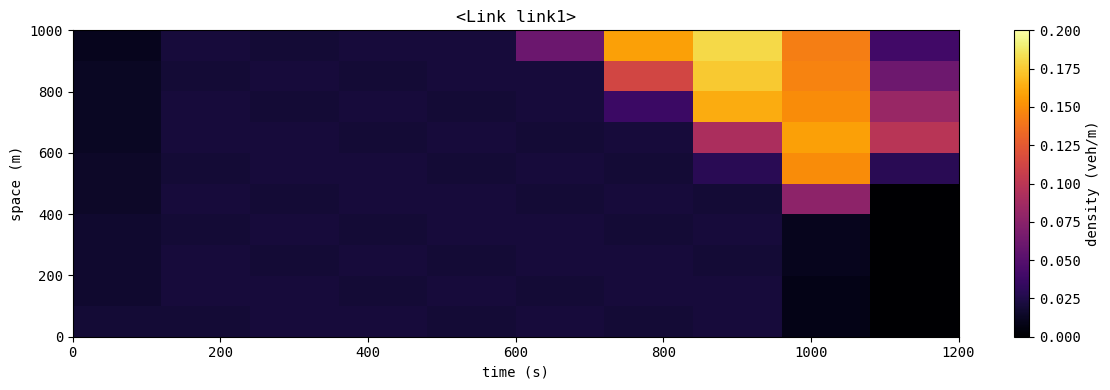

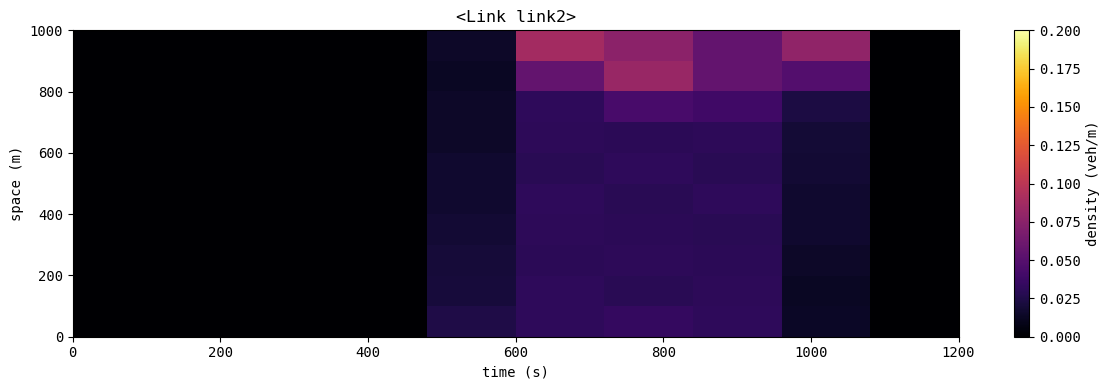

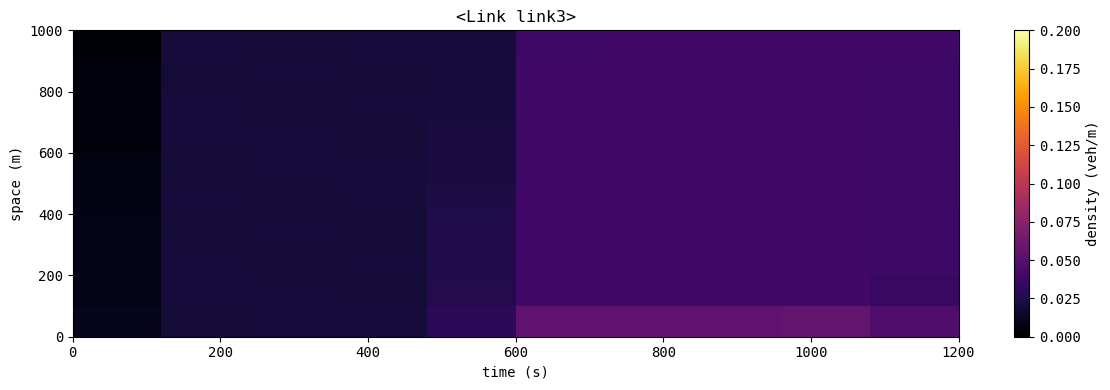

 drawing trajectories...


  0%|          | 0/3 [00:00<?, ?it/s]

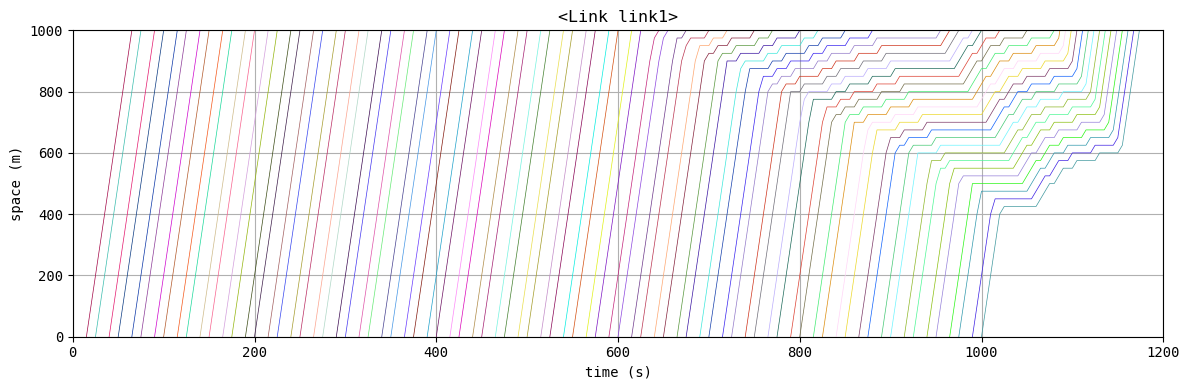

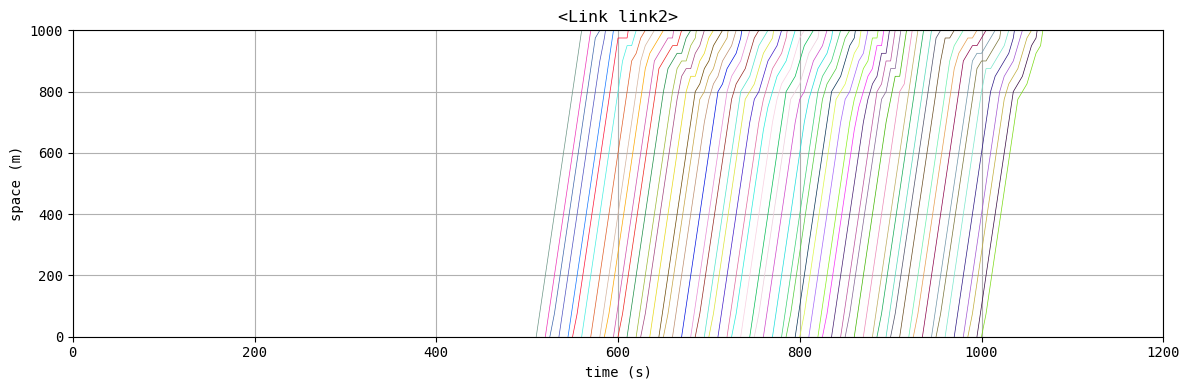

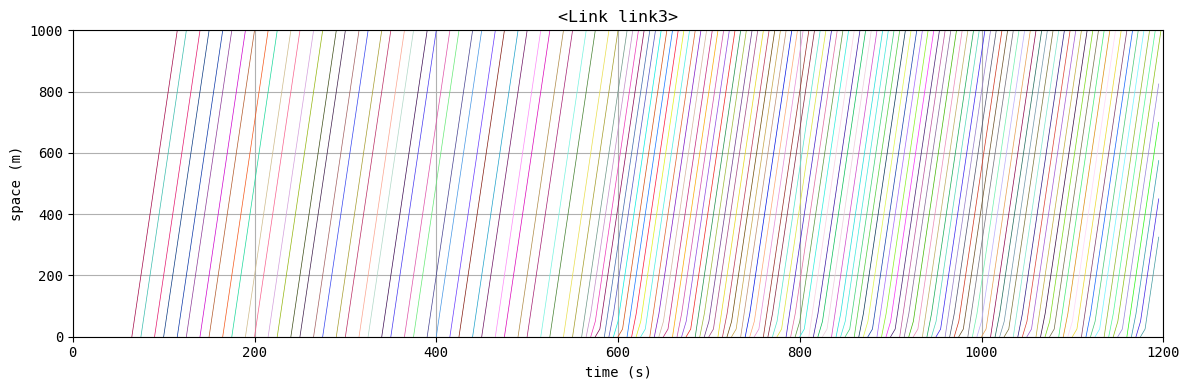

 drawing trajectories in consecutive links...


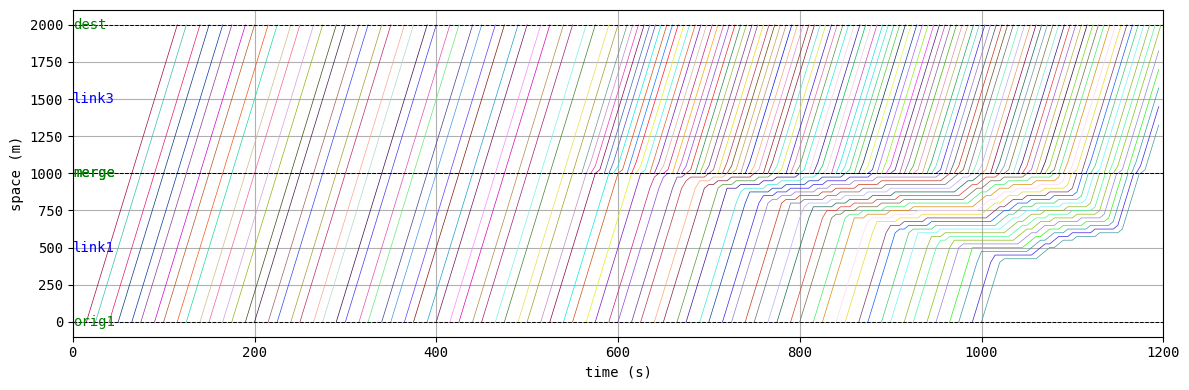

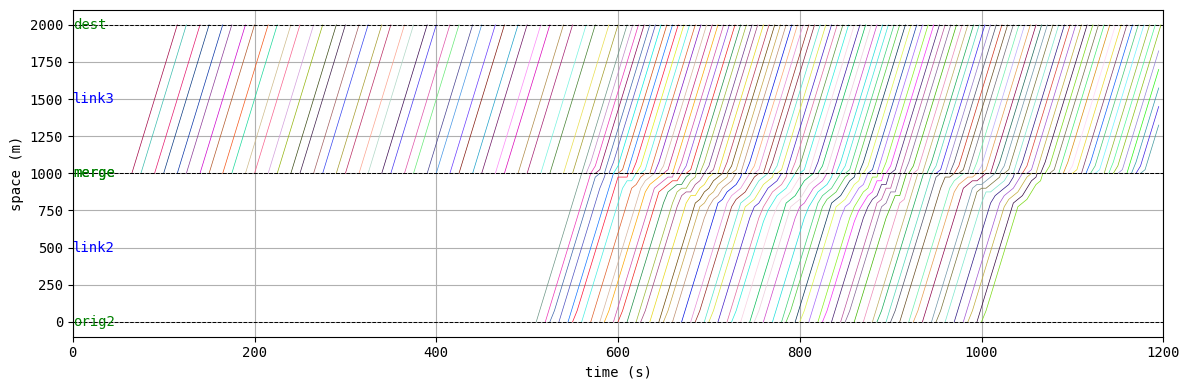

In [10]:
W.analyzer.time_space_diagram_density()
W.analyzer.time_space_diagram_traj()

W.analyzer.time_space_diagram_traj_links([["link1", "link3"], ["link2", "link3"]])

リンクの累積曲線，実旅行時間，瞬間旅行時間のプロットです．

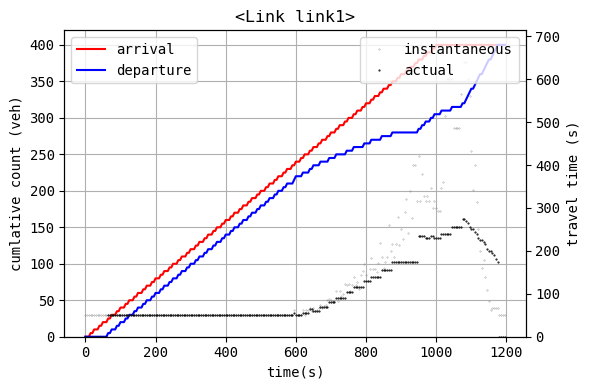

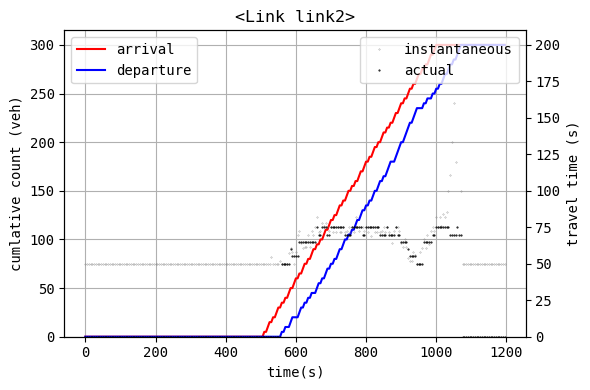

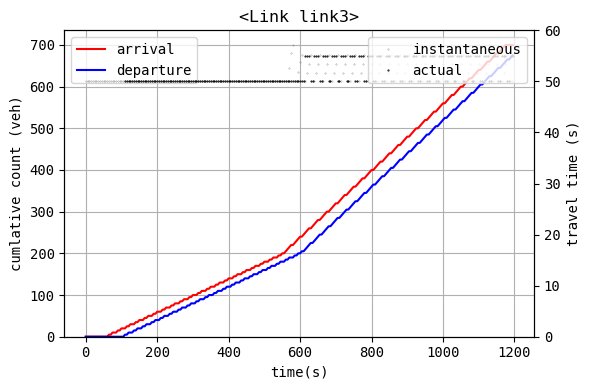

In [11]:
W.analyzer.cumulative_curves()

### エリア・ネットワーク規模

MFDです

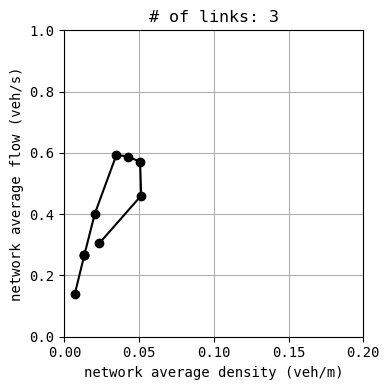

In [12]:
W.analyzer.macroscopic_fundamental_diagram()

ネットワーク全体の交通状況のスナップショットも作成できます

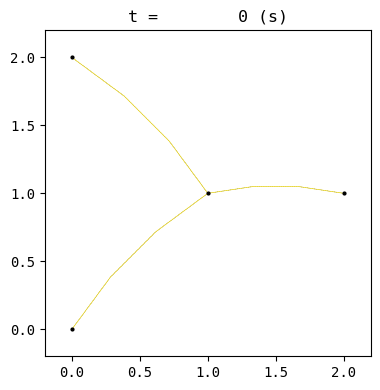

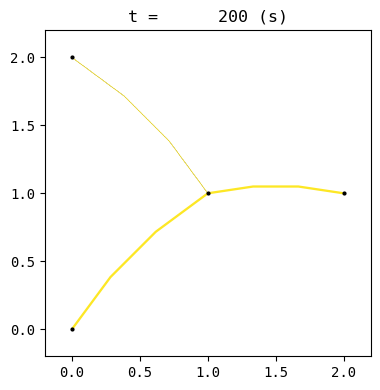

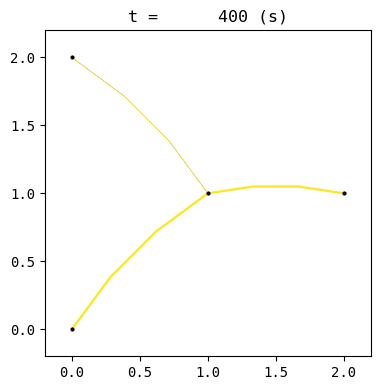

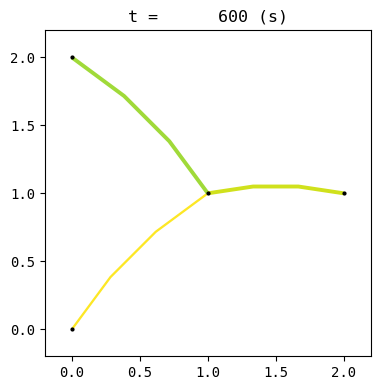

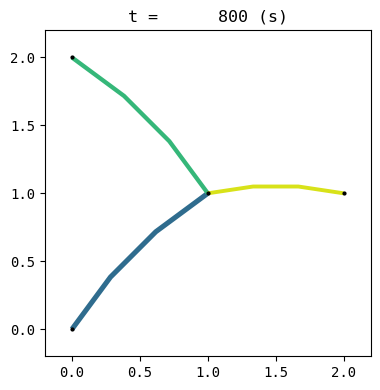

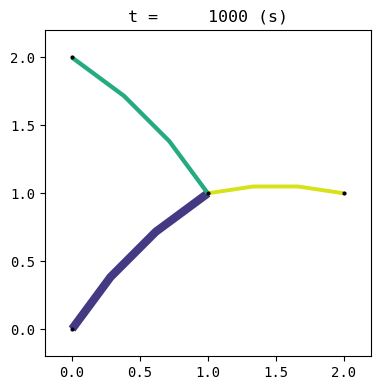

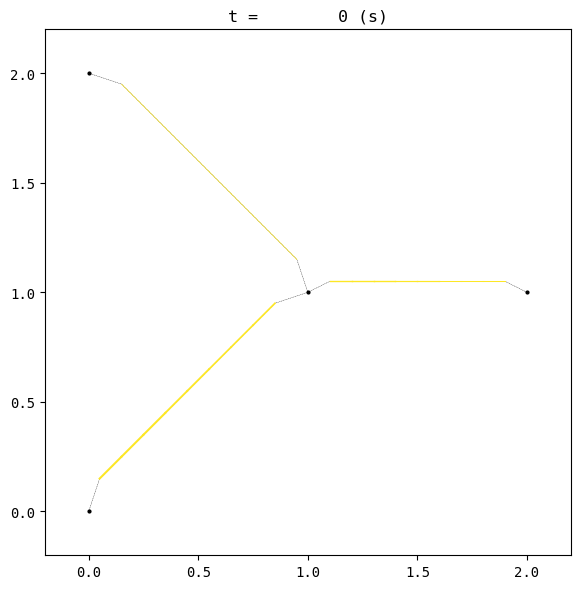

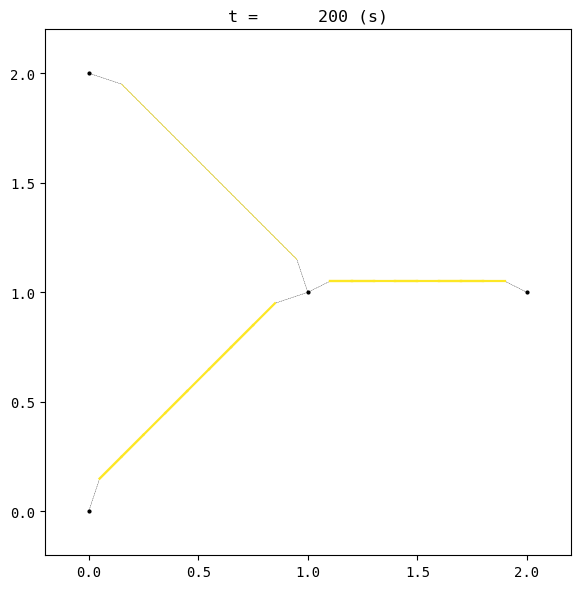

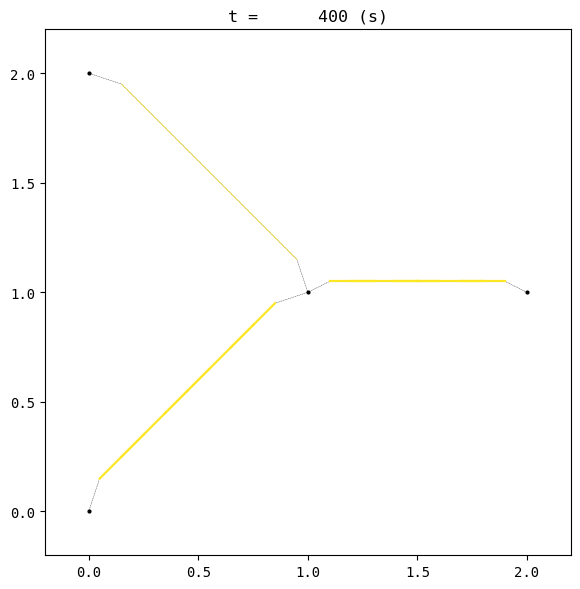

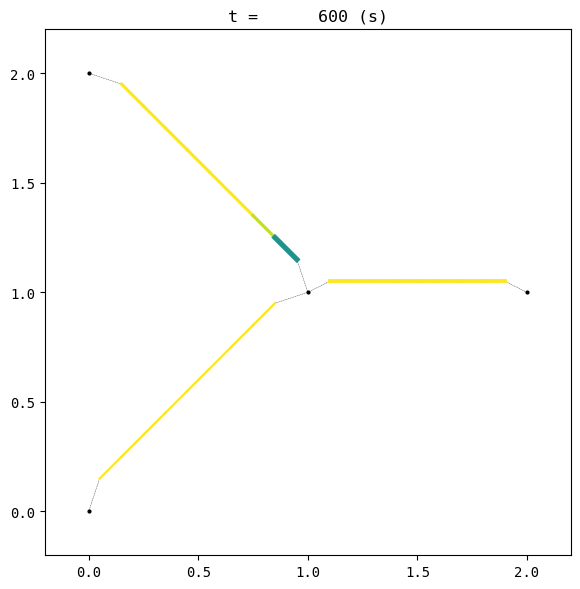

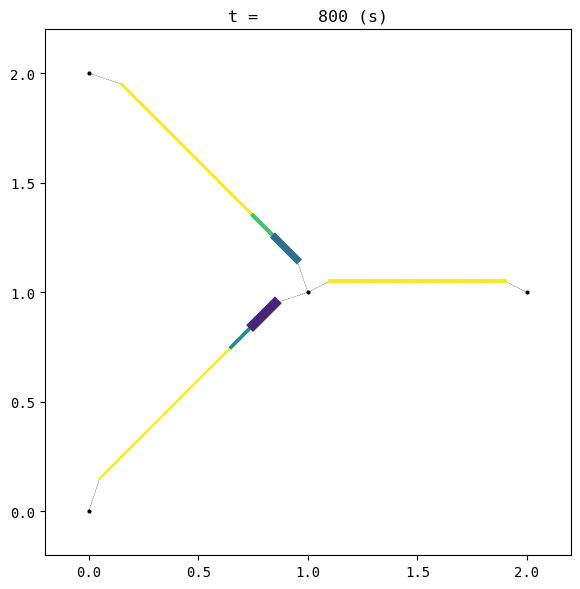

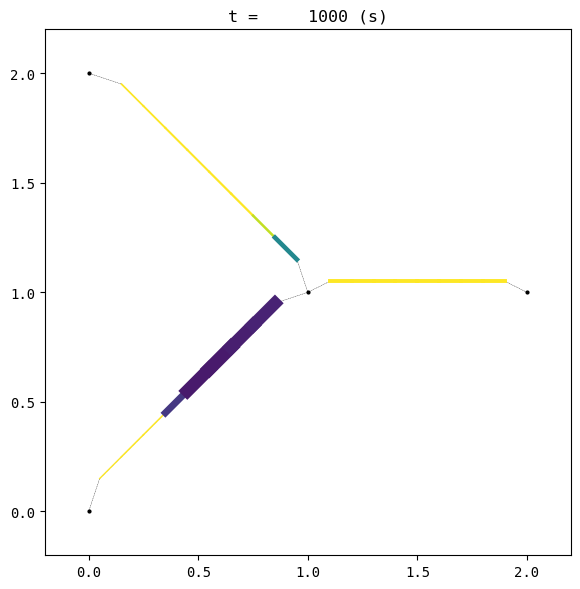

In [13]:
for t in list(range(0,W.TMAX,int(W.TMAX/6))):
    W.analyzer.network(t, detailed=0, network_font_size=0, figsize=(4,4))
for t in list(range(0,W.TMAX,int(W.TMAX/6))):
    W.analyzer.network(t, detailed=1, network_font_size=0)

ネットワーク全体の交通状況をgifアニメにすることもできます．
デフォルトでは，リンク単位の交通状況，リンク内の区間ごとの交通状況（ネットワークの形状によっては，あまりわかりやすくない），一部の車両の移動軌跡を可視化できます．
リンクの幅が太いほど車両台数・密度が大きく，色が暗いほど速度が小さいことを意味します．
大規模なシナリオでの作成速度は非常に遅いので要注意です．

 generating animation...


  0%|          | 0/30 [00:00<?, ?it/s]

 generating animation...


  0%|          | 0/30 [00:00<?, ?it/s]

 generating animation...


  0%|          | 0/120 [00:00<?, ?it/s]

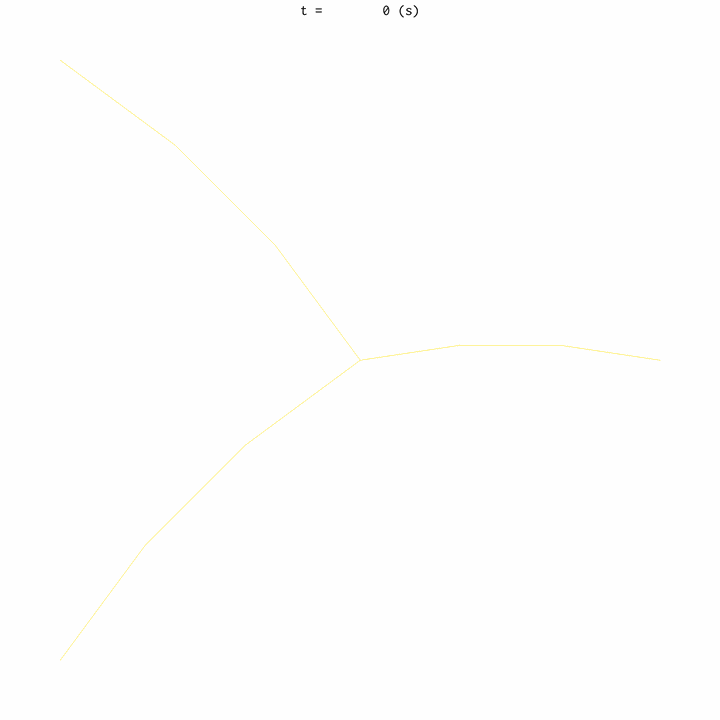

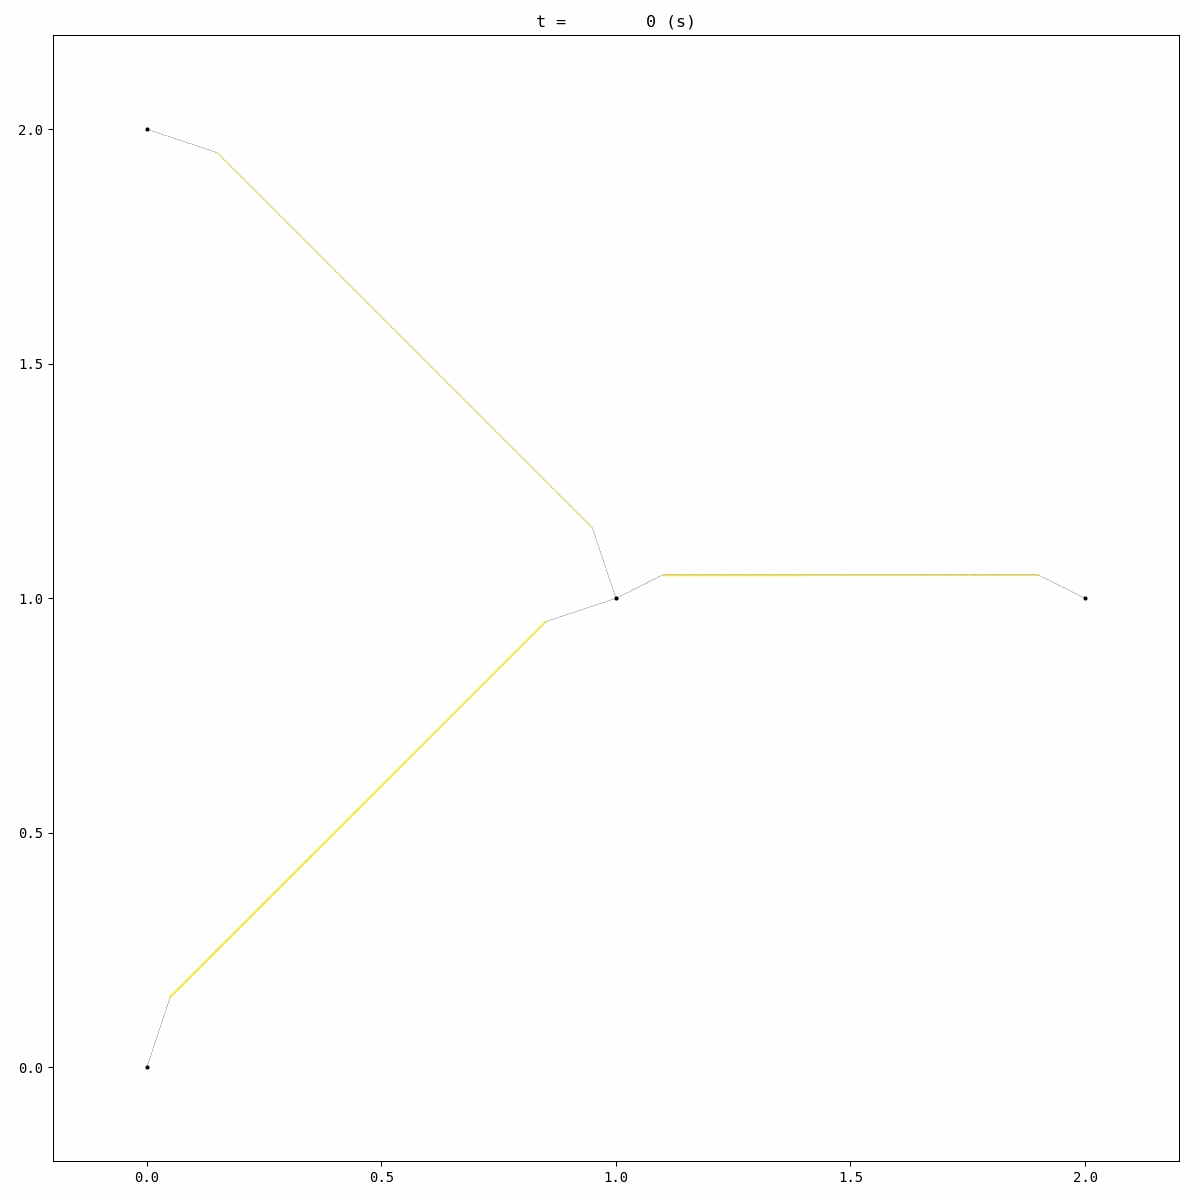

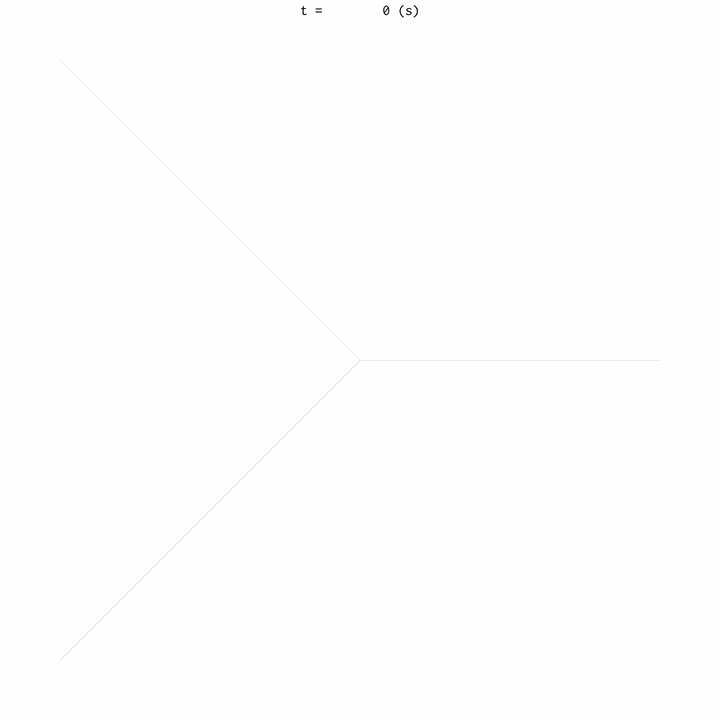

In [14]:
W.analyzer.network_anim(animation_speed_inverse=15, detailed=0, network_font_size=0)
W.analyzer.network_anim(detailed=1, network_font_size=0, figsize=(12,12))
W.analyzer.network_fancy(animation_speed_inverse=15, sample_ratio=0.3, interval=5, trace_length=5)

from IPython.display import display, Image
with open("outsimple_demo/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))
with open("outsimple_demo/anim_network1.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))
with open("outsimple_demo/anim_network_fancy.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))
    

### 車両単位

ある一台の車両の走行ログも可視化できます．走行したリンクとそのときの速度です．

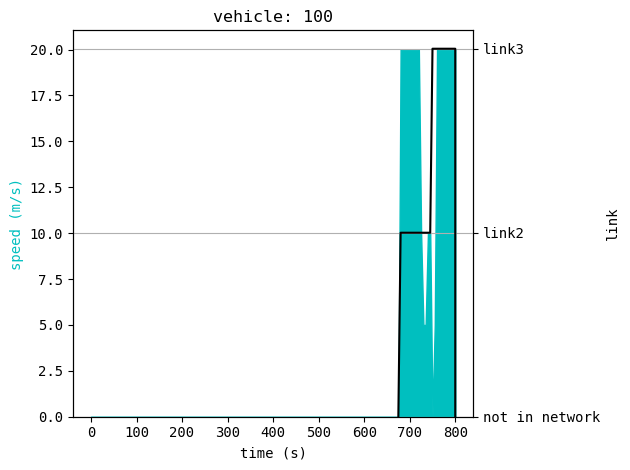

In [15]:
W.analyzer.plot_vehicle_log("100")

### GUIによる可視化

GUIによりシミュレーション結果を可視化し，探索的に分析することもできます．ネットワーク交通状態の再生・停止，選択リンクの時空間図描画，結果のエクスポートが可能です．

In [ ]:
from uxsim.ResultGUIViewer import ResultGUIViewer
ResultGUIViewer.launch_World_viewer(W)

# Sioux Fallsネットワーク

交通工学のベンチマークとして有名なSioux Fallsネットワークのシミュレーション例です．

In [18]:
# シミュレーション本体の定義
W = World(
    name="simple_demo",
    deltan=5,
    tmax=7200,
    print_mode=1, save_mode=1, show_mode=0,
    random_seed=0
)

# シナリオ定義
#CSVファイル読込
W.load_scenario_from_csv("dat/siouxfalls_nodes.csv", "dat/siouxfalls_links.csv", "dat/siouxfalls_demand.csv")

# シミュレーション実行
#最後までシミュを回す
W.exec_simulation()

# 結果可視化
W.analyzer.print_simple_stats()

W.analyzer.network_anim(animation_speed_inverse=15, detailed=0, network_font_size=0)

simulation setting:
 scenario name: simple_demo
 simulation duration:	 7200 s
 number of vehicles:	 34690 veh
 total road length:	 314000.0 m
 time discret. width:	 5 s
 platoon size:		 5 veh
 number of timesteps:	 1440
 number of platoons:	 6938
 number of links:	 76
 number of nodes:	 24
 setup time:		 1.53 s
simulating...
      time| # of vehicles| ave speed | computation time
       0 s|        0 vehs|   0.0 m/s |     0.00 s
     600 s|     2445 vehs|   7.3 m/s |     1.34 s
    1200 s|     5575 vehs|   6.9 m/s |     3.01 s
    1800 s|     8360 vehs|   6.6 m/s |     5.27 s
    2400 s|     9880 vehs|   6.0 m/s |     7.40 s
    3000 s|    10335 vehs|   5.3 m/s |     9.34 s
    3600 s|    12605 vehs|   5.2 m/s |    11.47 s
    4200 s|    13440 vehs|   4.9 m/s |    13.38 s
    4800 s|    14090 vehs|   4.8 m/s |    15.10 s
    5400 s|    10895 vehs|   5.0 m/s |    16.64 s
    6000 s|     7510 vehs|   5.6 m/s |    17.84 s
    6600 s|     4395 vehs|   6.1 m/s |    18.47 s
    7195 s|     1

  0%|          | 0/180 [00:00<?, ?it/s]

In [ ]:
from uxsim.ResultGUIViewer import ResultGUIViewer
ResultGUIViewer.launch_World_viewer(W)

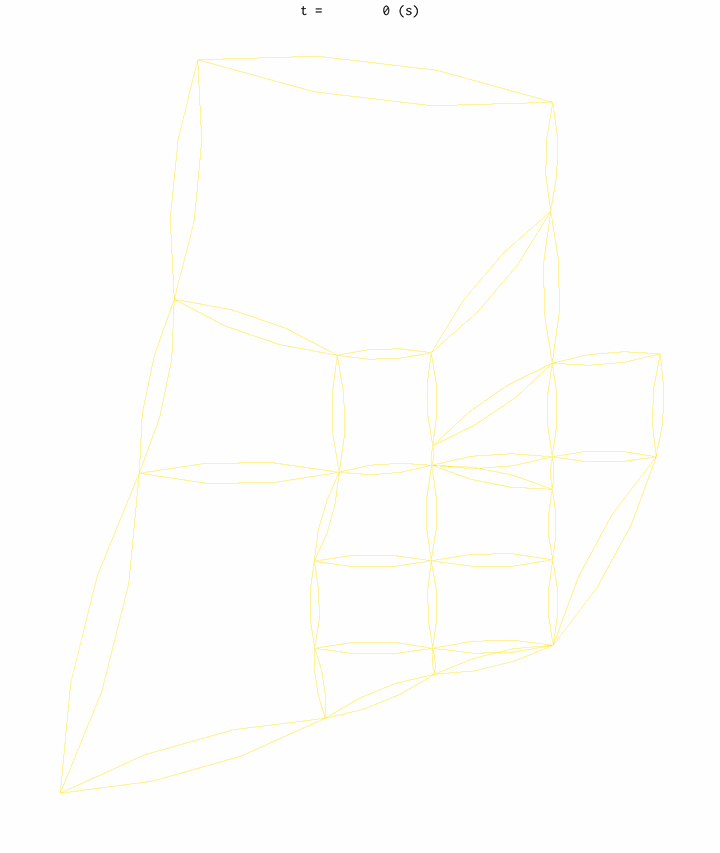

In [19]:
with open("outsimple_demo/anim_network0.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))